<a href="https://colab.research.google.com/github/Shivani985/Coursera_Capstone/blob/master/Exploring_venues_in_Kolkata%2CIndia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring venues in Kolkata, India

**Table of Contents**

1.Introduction  
2.Data Collection from APIs  
3.Data Cleaning  
4.Methodolgy  
5.Analysis  
6.Results and Discussion  
7.Conclusion  

In [1]:
import numpy as np # library to handle data in a vectorized manner
 
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
 
import json # library to handle JSON files
 
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
 
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
 
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
 
print('Libraries imported.')

Libraries imported.


# Introduction
This project is to identify the places in **Kolkata, India** based on their ratings and prices.In this notebook, we will identify different places in the city of Kolkata,India using Foursquare API and Zomato API, to help visitors select their restaurant sthat suits them. On visiting th new places our first consern will be their restaurants with good rating and also fits in their budgets.

Using the two APIs and our Data science knowledge we will analyse different places.

In [2]:
K_latitude=22.572645
K_longitude=88.363892

address = 'Kolkata'

geolocator = Nominatim(user_agent="kolkata")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kolkata are {}, {}.'.format(latitude, longitude))
Kolkata_map = folium.Map(location = [K_latitude,K_longitude])
folium.Marker([latitude,longitude]).add_to(Kolkata_map)
Kolkata_map

The geograpical coordinate of Kolkata are 22.54541245, 88.3567751581234.


Let's use the folium library to create a complete map zoomed on **Kolkata**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

# Define Foursquare Credentials
We begin by fetching a total of all venues in Kolkata upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [3]:
CLIENT_ID = 'Enter-your-client-id'
CLIENT_SECRET = 'Enter-your-client-secret'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100  
VERSION = '20200629'

# Data Collection
We will fetch the required data using the two different APIs.
Foursqaure API -> We will use the Foursquare API to fetch venues in Kolkata.
Zomato API -> The Zomato API provides information about various venues including the complete address, user ratings, price for one person, price range and a lot more.

# KOLKATA
Kolkata is the capital of West Bengal state located on the banks of the Hooghly river. For many years the city used to be known as Calcutta. Traditionally, it is known for its quite large river port, highly advanced and modern educational establishments, beautiful palaces and ancient temples.

Kolkata is an important economic, political, cultural, and educational center of today's India, and also one of its famous tourist destinations.

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**->** Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.  
**->** We will set the radius as 4 Kilometers.  
**->** The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.  

In [5]:
pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        K_latitude, 
                                                                        K_longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
    

Total 100 venues fetched within a total radius of 4.0 Km


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 35 venues fetched within a total radius of 4.0 Km


# Zomato API

The Zomato API allows its search API to search for a given venue based on certain search filters such as query, latitude, longitude and much more. Zomato also requires Zomato user key which can be accessed with a devloper account.

In [6]:
headers = {'user-key': 'Enter your user-key'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])


Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

# Data Cleaning 
The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly.**

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [7]:
Kolkata_map = folium.Map(location = [K_latitude,K_longitude], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(Kolkata_map)  


Kolkata_map

In [8]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [9]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [10]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Blue & Beyond,Pub,22.5591,88.3533,Blue And Beyond,22.5591,88.3532,1600.0,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",0.0000,-0.0001
1,Lalit Great Eastern Hotel,Hotel,22.5680,88.3500,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,1500.0,3.0,3.8,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",0.0000,0.0000
2,Peter Cat,Indian Restaurant,22.5524,88.3525,Peter Cat,22.5525,88.3526,1000.0,3.0,4.4,"18A, Park Street, Park Street Area, Kolkata",0.0001,0.0001
3,The Blue Poppy,Asian Restaurant,22.5485,88.3514,Blue Poppy-Thakali,22.5486,88.3512,500.0,2.0,4.0,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",0.0001,-0.0002
4,Arsalan,Mughlai Restaurant,22.5539,88.3541,Arsalan,22.5539,88.3543,1000.0,3.0,4.2,"119 A, Muzaffar Ahmed Street, Mirza Ghalib Str...",0.0000,0.0002
5,Anand Restaurant,South Indian Restaurant,22.5673,88.3549,Anand Restaurant,22.5675,88.3550,500.0,2.0,4.4,"19, C.R. Avenue, Near Dalhousie Square Area, C...",0.0002,0.0001
6,College Street Market,Bookstore,22.5763,88.3636,Indian Coffee House,22.5761,88.3639,300.0,1.0,3.0,"15, Bankim Chatterjee Street, College Street, ...",-0.0002,0.0003
7,Cafe Coffee Day,Café,22.5776,88.3904,Cafe Coffee Day,22.5778,88.3904,700.0,2.0,3.6,"P-183 A, CIT Road, Scheme 6M, Kankurgachhi, Ko...",0.0002,0.0000
8,Oxford Bookstore,Bookstore,22.5537,88.3517,Burgrill,22.5537,88.3518,500.0,2.0,4.0,"12B/2, Park Street Park, Opposite Oxford Book ...",0.0000,0.0001
9,Esplanade,Neighborhood,22.5642,88.3523,Nutri Bowl,22.5642,88.3524,200.0,1.0,4.1,"3A, 1st Floor, Jawaharlal Nehru Road, Esplanad...",0.0000,0.0001


I'll now select the venue name from **Zomato API**. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [11]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [12]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0
1,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,3.0,3.8,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0
2,Indian Restaurant,Peter Cat,22.5525,88.3526,3.0,4.4,"18A, Park Street, Park Street Area, Kolkata",500.0
3,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.0,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0
4,Mughlai Restaurant,Arsalan,22.5539,88.3543,3.0,4.2,"119 A, Muzaffar Ahmed Street, Mirza Ghalib Str...",500.0


In [13]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 71


# Methodology 
This project aims at identifying the venues in Kolkata based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Kolkata, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

# Analysis 
The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

<BarContainer object of 35 artists>

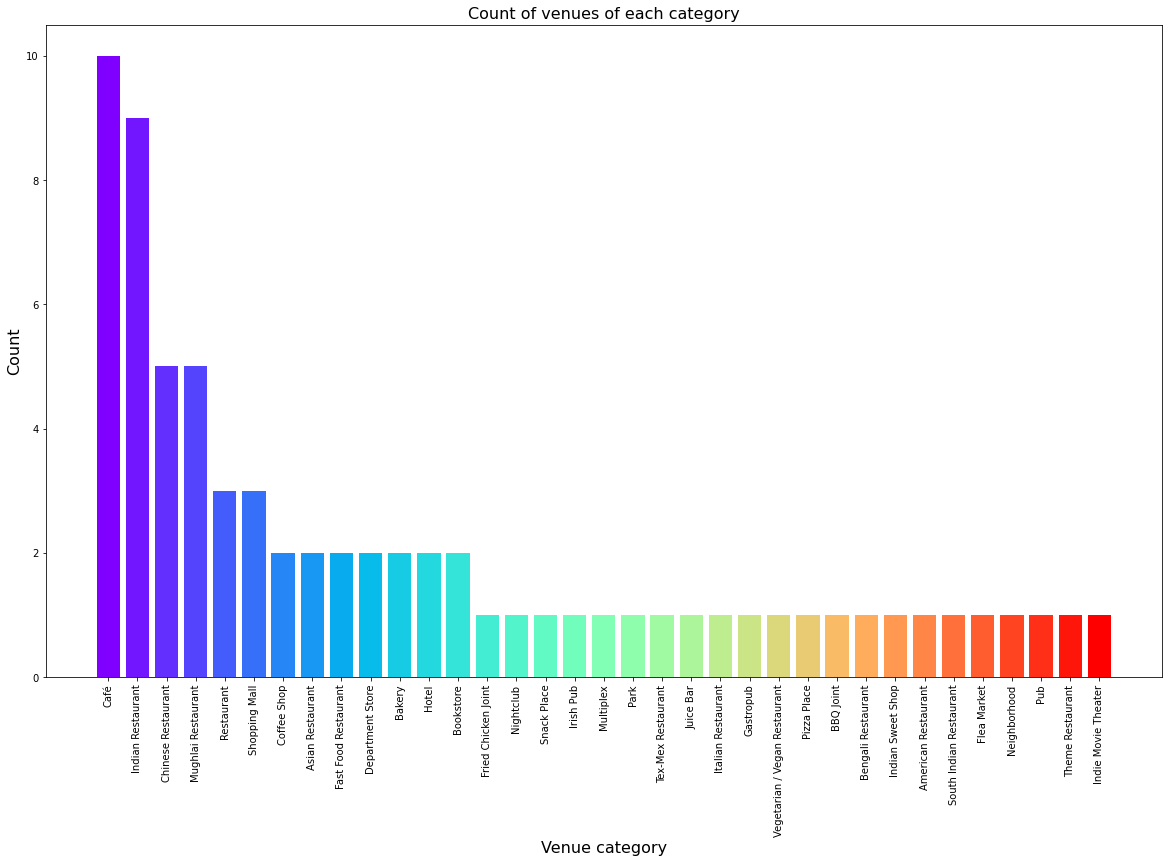

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

#Rating
Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

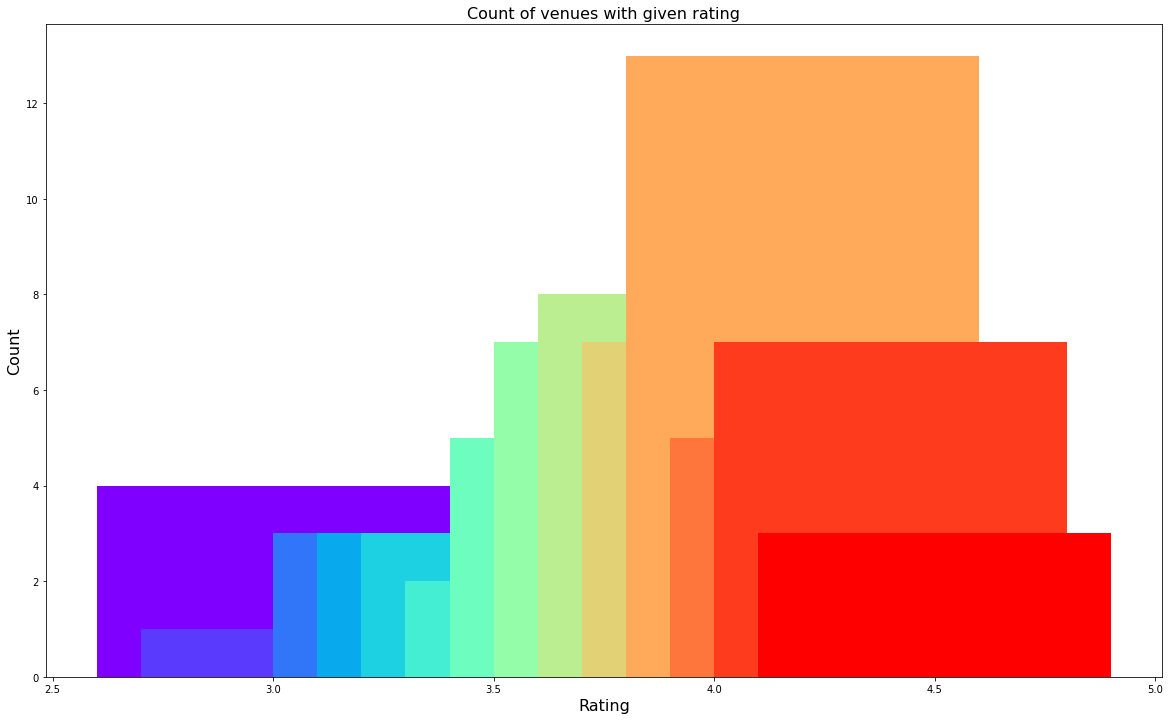

In [15]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [16]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [17]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

Kolkata_map = folium.Map(location = [K_latitude,K_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(Kolkata_map)  

#Kolkata_map.save("maps/Venues Ratings.html")
Kolkata_map

# Price
We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

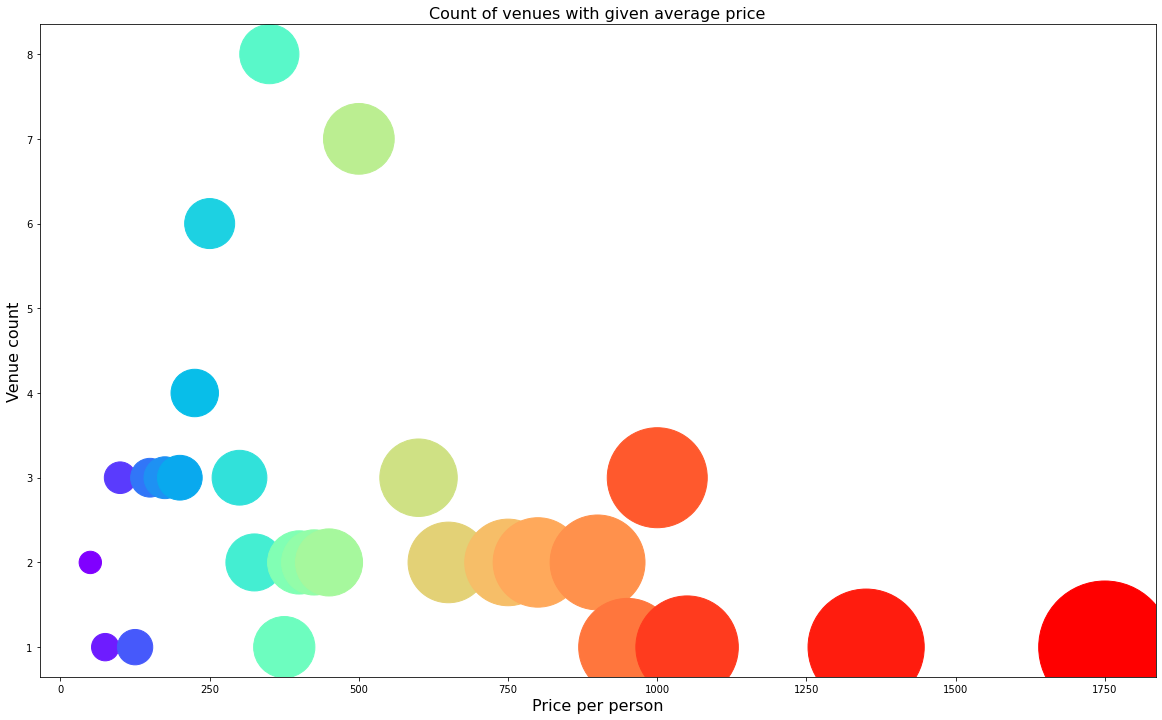

In [18]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In [19]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

Kolkata_map = folium.Map(location = [K_latitude,K_longitude], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(Kolkata_map)  

#Kolkata_map.save("maps/Venues Prices.html")
Kolkata_map

#Clustering
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [20]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0,Good
1,1,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,3.0,3.8,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0,Good
2,0,Indian Restaurant,Peter Cat,22.5525,88.3526,3.0,4.4,"18A, Park Street, Park Street Area, Kolkata",500.0,Very good
3,0,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.0,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0,Good
4,0,Mughlai Restaurant,Arsalan,22.5539,88.3543,3.0,4.2,"119 A, Muzaffar Ahmed Street, Mirza Ghalib Str...",500.0,Very good


In [21]:
Kolkata_map = folium.Map(location = [K_latitude,K_longitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(Kolkata_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(Kolkata_map)

#Kolkata_map.save("maps/Venues Clusters.html")
Kolkata_map

In [22]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Peter Cat,22.5525,88.3526,3.0,4.4,"18A, Park Street, Park Street Area, Kolkata",500.0,Very good
1,0,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.0,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0,Good
2,0,Mughlai Restaurant,Arsalan,22.5539,88.3543,3.0,4.2,"119 A, Muzaffar Ahmed Street, Mirza Ghalib Str...",500.0,Very good
3,0,South Indian Restaurant,Anand Restaurant,22.5675,88.3550,2.0,4.4,"19, C.R. Avenue, Near Dalhousie Square Area, C...",250.0,Very good
4,0,Bookstore,Indian Coffee House,22.5761,88.3639,1.0,3.0,"15, Bankim Chatterjee Street, College Street, ...",150.0,Okay
5,0,Café,Cafe Coffee Day,22.5778,88.3904,2.0,3.6,"P-183 A, CIT Road, Scheme 6M, Kankurgachhi, Ko...",350.0,Good
6,0,Bookstore,Burgrill,22.5537,88.3518,2.0,4.0,"12B/2, Park Street Park, Opposite Oxford Book ...",250.0,Good
7,0,Neighborhood,Nutri Bowl,22.5642,88.3524,1.0,4.1,"3A, 1st Floor, Jawaharlal Nehru Road, Esplanad...",100.0,Very good
8,0,Café,Raj Spanish Cafe,22.5584,88.3542,2.0,4.1,"7, Ground Floor, Sudder Street, New Market Are...",300.0,Very good
9,0,BBQ Joint,Oasis,22.5532,88.3524,2.0,4.0,"33, Park Street, Park Street Area, Kolkata",450.0,Good


In [23]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.82 and rating spread around 3.93


In [24]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0,Good
1,1,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,3.0,3.8,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0,Good
2,1,Nightclub,Tantra - The Park,22.5541,88.3514,4.0,3.5,"The Park, 17, Park Street, Park Street Area, K...",1750.0,Good
3,1,Chinese Restaurant,Big Boss,22.5469,88.3879,3.0,4.0,"54C, Matheswartala Road, Tangra, Kolkata",650.0,Good
4,1,Chinese Restaurant,Beijing,22.5465,88.3873,3.0,4.2,"77/1, Christopher Road, Tangra, Kolkata",900.0,Very good
5,1,Chinese Restaurant,Marco Polo,22.5516,88.3538,3.0,4.5,"24, Park Centre Building, Park Street Area, Ko...",800.0,Very good
6,1,Indian Restaurant,Bombay Brasserie,22.5387,88.3656,3.0,4.2,"33, 5th Floor, Quest Mall, Syed Ali Amir Avenu...",950.0,Very good
7,1,Gastropub,Monkey Bar,22.5443,88.3523,3.0,4.3,"801 A - 901 A, Fort Knox Building 6, Abindrana...",750.0,Very good
8,1,Indian Restaurant,SpiceKlub,22.5518,88.3536,4.0,3.9,"1st Floor, 24, Park Street, Annex Building, Ma...",1050.0,Good
9,1,American Restaurant,TGI Fridays,22.5384,88.3513,3.0,4.2,"2nd Floor, 10/3 Forum Courtyard, Lala Rajpat r...",900.0,Very good


In [25]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.40 and rating spread around 4.09


# Results and Discussion
After collecting data from the Foursquare and Zomato APIs, we got a list of 71
different venues. However, not all venues from the two APIs were identical. Hence,
we had to inspect their latitude and longitude values as well as their names to
combine them and remove all the outliers.
The purpose of this project was to explore the places that a person visiting Kolkata
could explore. The venues have been identified using Foursquare and Zomato APIs
and have been plotted on the map.